In [26]:
%time
import numpy as np

def readdata(path):
    x=[] # lat, long
    temp=[]
    with open(path) as file:
        lines=file.read().split('\n')
        for line in lines:
            if len(line)<2:
                continue
            line=line.split(',')
            x.append([float(line[0]),float(line[1])])
            temp.append(float(line[2]))
    return np.array(x),np.array(temp)

train_x,train_y=readdata("gptrain.csv")
#print(train_x)
#print(train_y)
test_x,test_y=readdata("gptest.csv")
#print(test_x)
#print(test_y)

Wall time: 0 ns


In [27]:
import math
def Ker(a,b):
    sigma2=0.866**2
    s=0
    for i in range(len(a)):
        s += (a[i]-b[i])**2
    return math.exp(-s/(2*sigma2))
# K(te,tr)
train_l=len(train_x)
test_l=len(test_x)
K_te_tr=np.array([[Ker(test_x[i],train_x[j]) for j in range(train_l)]for i in range(test_l)])

# Ktr, invert
K_tr_tr=np.array([[Ker(train_x[i],train_x[j]) for j in range(train_l)]for i in range(train_l)])
K_tr_tr_invert=np.linalg.inv(K_tr_tr)

# compute conditional test mean
mx=20
dat_mte=train_y-mx
m_te_con=mx + (K_te_tr @ K_tr_tr_invert @ dat_mte)
print("conditional test mean")
print(m_te_con)

# compute mean squared error
m_sqrerr=0
for i in range(len(test_y)):
    m_sqrerr =  (m_te_con[i]-test_y[i])**2
m_sqrerr /= len(test_y)
print("true value found")
print(test_y)
print("mean squared error=",m_sqrerr)

conditional test mean
[ 14.26880633 -73.06558265  14.61820814  18.78940398  11.46167127
 -60.20940761  19.69791631  23.69517697  -7.59168743  23.04869716
  12.50774735]
true value found
[16.3 22.1 20.4 14.8 19.7 20.5 18.4 19.1 22.6 22.9 17.4]
mean squared error= 2.1758305462474383


In [47]:
# compute conditional test covariance matrix, using 2 methods to compare

# method 1--invert matrix
K_te_te=np.array([[Ker(test_x[i],test_x[j]) for j in range(test_l)]for i in range(test_l)])
K_tr_te=np.array([[Ker(train_x[i],test_x[j]) for j in range(test_l)]for i in range(train_l)])
comat_te_con_1=K_te_te - (K_te_tr @ K_tr_tr_invert @ K_tr_te)
print("conditional test covariance matrix___method 1")
print(comat_te_con_1.shape)
print(comat_te_con_1)

conditional test covariance matrix___method 1
(11, 11)
[[ 9.61672144e-02 -7.22441285e-04  6.52762643e-05  4.09324043e-03
   2.69654972e-04 -4.08863824e-04  1.75344528e-03  3.54970207e-04
  -1.69271499e-04  7.81496777e-04 -1.91486188e-02]
 [-7.22441285e-04  2.19242880e-02 -4.53539127e-04 -8.17971055e-04
   3.79739375e-04  1.73640017e-02  4.83582499e-04  4.08597797e-05
   1.77103780e-03 -5.93926790e-03  1.54146834e-04]
 [ 6.52762644e-05 -4.53539142e-04  8.50069884e-05  7.96309856e-05
  -4.13995063e-05 -3.69110783e-04 -6.45388895e-05 -4.59389842e-06
  -8.52642301e-06  1.02550741e-03  3.22364624e-05]
 [ 4.09324043e-03 -8.17971055e-04  7.96309855e-05  8.45714734e-01
   1.26513008e-04  9.19511536e-05 -2.64677912e-03  1.37781870e-05
  -1.49025173e-04  7.02684122e-04  1.76889904e-04]
 [ 2.69654972e-04  3.79739375e-04 -4.13995065e-05  1.26513008e-04
   9.41194200e-02  1.49985543e-04 -6.29958050e-04 -1.40069457e-03
  -2.56498247e-05 -1.30744791e-03 -2.87905238e-03]
 [-4.08863824e-04  1.73640017e

In [79]:
# method 2--np.linalg.solve
def merge(A):
    lines=[]
    for i in range(len(A)):
        lines.append(np.concatenate(A[i],axis=1))
    res=np.concatenate(lines,axis=0)
    return res

def cmpt_cov_2(K_te_tr,K_tr_tr,K_te_te,K_tr_te):
    A=[[np.identity(len(K_te_te)),K_te_tr],[np.zeros((len(K_tr_tr),len(K_te_te))),K_tr_tr]]
    A=merge(A)
    B=merge([[K_te_te],[K_tr_te]])
    comat_and_invert=np.linalg.solve(A,B) # 104*11 ; [x,y]; y is K_tr^-1*K_tr_te, not square, easy to compute !!!
    res_l=len(K_te_tr)
    return comat_and_invert[:res_l,:res_l]

comat_te_con_2=cmpt_cov_2(K_te_tr,K_tr_tr,K_te_te,K_tr_te)
print("conditional test covariance matrix___method 2")
print(comat_te_con_2.shape)
print(comat_te_con_2)
print("maximum difference__")
print(max(abs((comat_te_con_2-comat_te_con_1).reshape(-1))))

conditional test covariance matrix___method 2
(11, 11)
[[ 9.61672144e-02 -7.22441285e-04  6.52762644e-05  4.09324043e-03
   2.69654972e-04 -4.08863824e-04  1.75344528e-03  3.54970207e-04
  -1.69271499e-04  7.81496777e-04 -1.91486188e-02]
 [-7.22441285e-04  2.19242880e-02 -4.53539152e-04 -8.17971055e-04
   3.79739375e-04  1.73640017e-02  4.83582502e-04  4.08597797e-05
   1.77103778e-03 -5.93926791e-03  1.54146834e-04]
 [ 6.52762644e-05 -4.53539152e-04  8.50069469e-05  7.96309856e-05
  -4.13995065e-05 -3.69110785e-04 -6.45388954e-05 -4.59389842e-06
  -8.52645297e-06  1.02550740e-03  3.22364624e-05]
 [ 4.09324043e-03 -8.17971055e-04  7.96309856e-05  8.45714734e-01
   1.26513008e-04  9.19511537e-05 -2.64677912e-03  1.37781870e-05
  -1.49025173e-04  7.02684122e-04  1.76889904e-04]
 [ 2.69654972e-04  3.79739375e-04 -4.13995065e-05  1.26513008e-04
   9.41194200e-02  1.49985543e-04 -6.29958050e-04 -1.40069457e-03
  -2.56498247e-05 -1.30744791e-03 -2.87905238e-03]
 [-4.08863824e-04  1.73640017e

In [62]:
%time
# find the range of latitude, longitude
trans=np.array(np.matrix(train_x).T)
lat=trans[0]
long=trans[1]
x_l=min(lat)
x_r=max(lat)
y_l=min(long)
y_r=max(long)

# create the grid, choose 70*70=4900 points
new_lat=np.array([x_l+i*(x_r-x_l)/70 for i in range(71)])
new_long=np.array([y_l+i*(y_r-y_l)/70 for i in range(71)])
grid_lat,grid_long=np.meshgrid(new_lat,new_long)
grid_lat=grid_lat.reshape(-1)
grid_long=grid_long.reshape(-1)
new_x=np.array(np.matrix([grid_lat,grid_long]).T)
new_l=len(new_x)
print(new_l)

# compute the covariance matrix
K_new_new=np.array([[Ker(new_x[i],new_x[j]) for j in range(new_l)]for i in range(new_l)])
K_new_tr=np.array([[Ker(new_x[i],train_x[j]) for j in range(train_l)]for i in range(new_l)])
K_tr_new=np.array([[Ker(train_x[i],new_x[j]) for j in range(new_l)]for i in range(train_l)])
comat_new_con_2=cmpt_cov_2(K_new_tr,K_tr_tr,K_new_new,K_tr_new)
new_cov_2=[comat_new_con_2[i][i] for i in range(new_l)]
new_cov_2=np.array(new_cov_2)
comat_new_con_1=K_new_new - (K_new_tr @ K_tr_tr_invert @ K_tr_new)
new_cov_1=[comat_new_con_1[i][i] for i in range(new_l)]
new_cov_1=np.array(new_cov_1)
print("conditional test covariance matrix for new created grid")
# print(comat_new_con)
# convariance list
# print(new_cov)
print("new_cov_1")
print(new_cov_1)
print("new_cov_2")
print(new_cov_2)
print("difference")
print(new_cov_2-new_cov_1)


Wall time: 0 ns
5041
conditional test covariance matrix for new created grid
new_cov_1
[0.99902453 0.99786799 0.99552959 ... 0.76632897 0.82762307 0.87855586]
new_cov_2
[0.99902453 0.99786799 0.99552959 ... 0.76632897 0.82762307 0.87855586]
difference
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.11022302e-16
 0.00000000e+00 1.11022302e-16]


In [64]:
print("maximum error")
print(max(abs(new_cov_2-new_cov_1)))

maximum error
3.702217421519549e-10


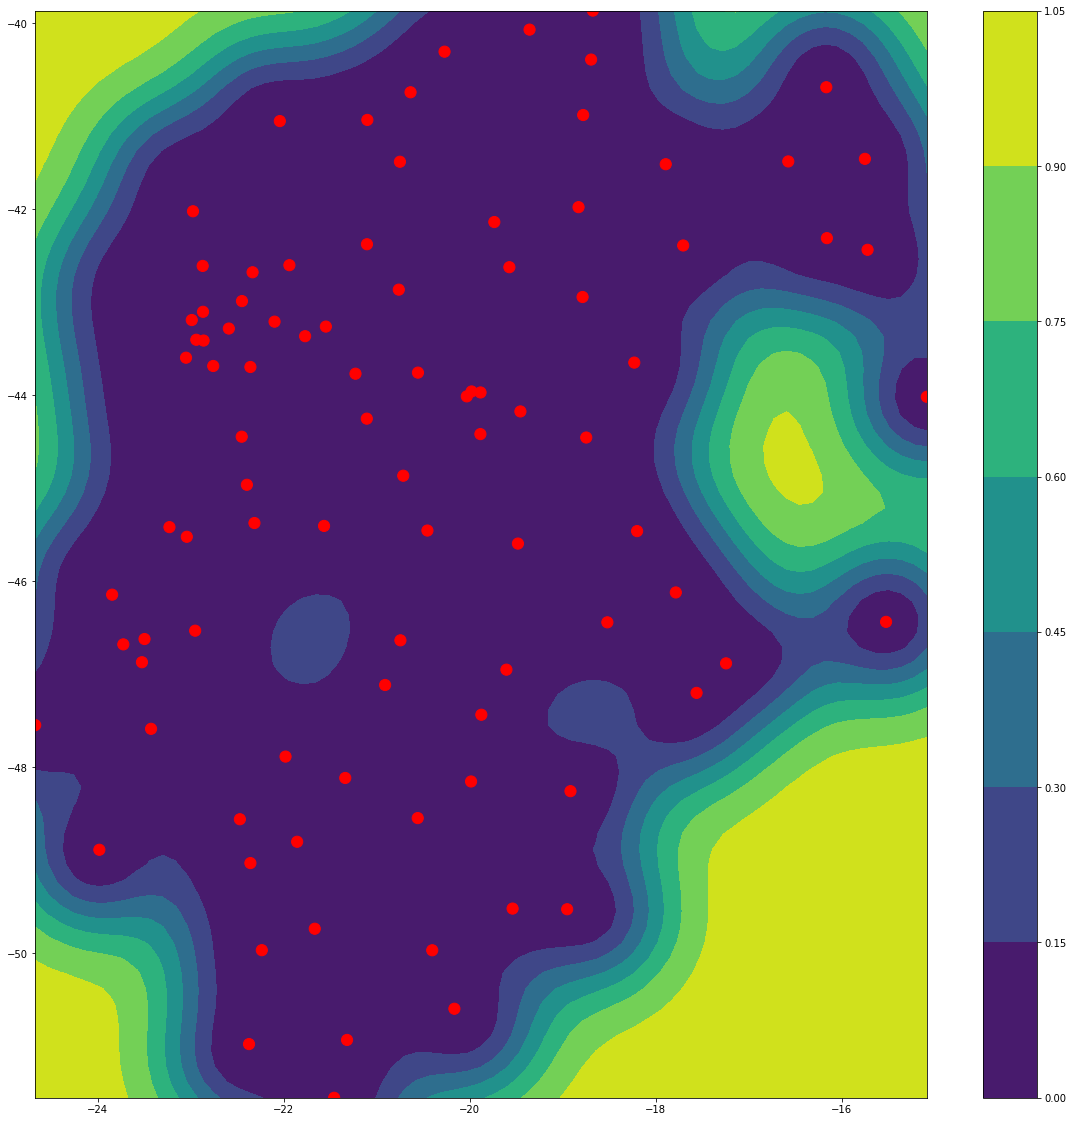

In [75]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,20

import matplotlib.pyplot as plt
figure, axes = plt.subplots()
for i in range(len(train_x)):
    center = plt.Circle(tuple(train_x[i]), 0.06, color='r')
    # axes.set_aspect( 1 )
    axes.add_artist( center )

new_cov=np.array(new_cov_2)
h = plt.contourf(grid_lat.reshape(71,-1), grid_long.reshape(71,-1), new_cov.reshape(71,-1))
plt.axis('scaled')
plt.colorbar()
plt.show()

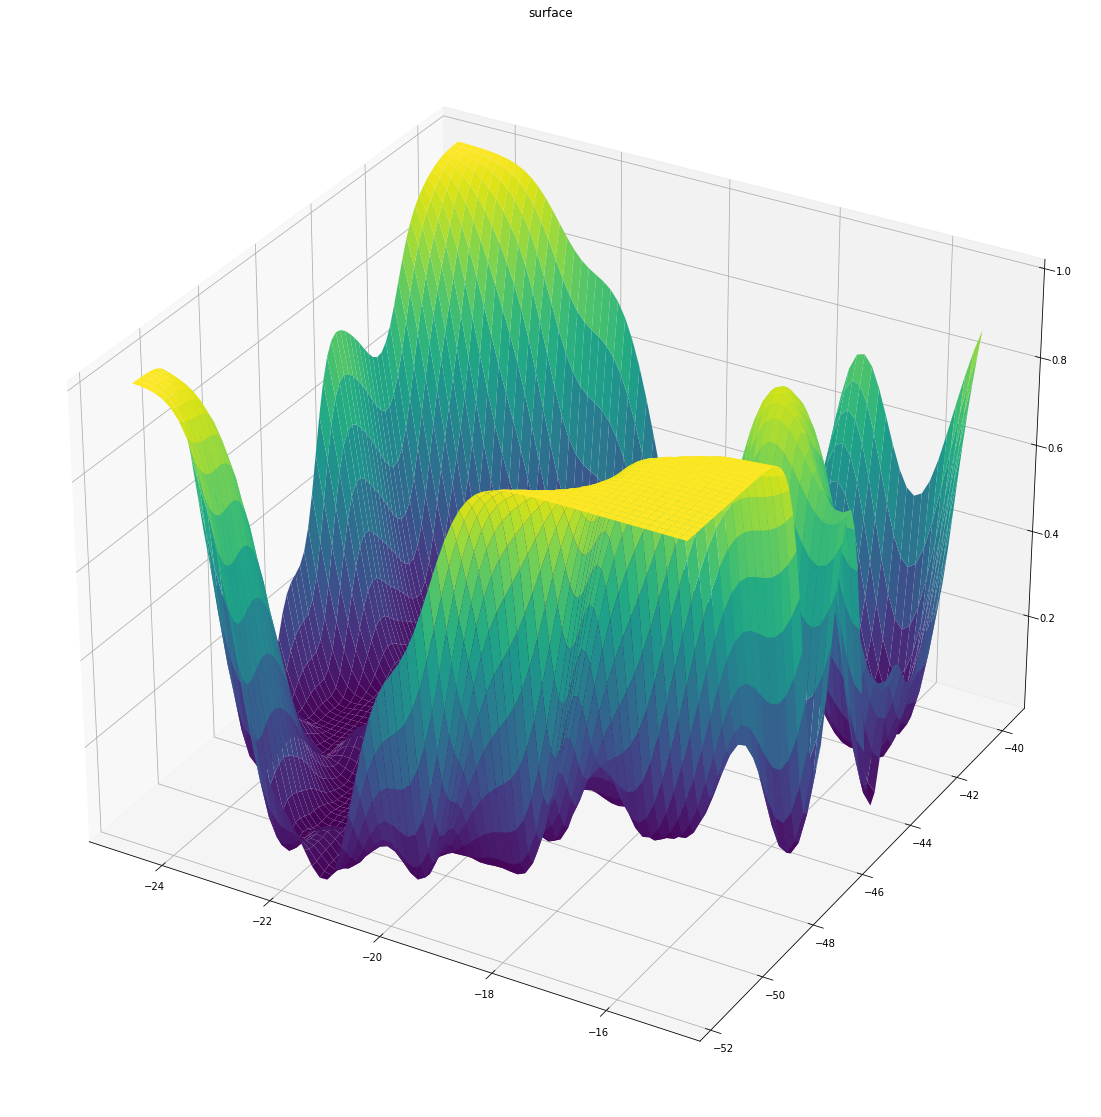

In [76]:
ax = plt.axes(projection='3d')
ax.plot_surface(grid_lat.reshape(71,-1), grid_long.reshape(71,-1), new_cov.reshape(71,-1), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface')

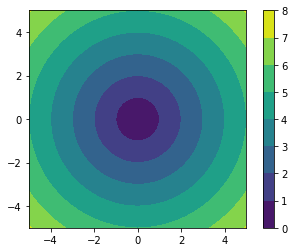

In [27]:
x = np.linspace(-5, 5, 101)
y = np.linspace(-5, 5, 101)

# full coorindate arrays
xx, yy = np.meshgrid(x, y)
zz = np.sqrt(xx**2 + yy**2)
xx.shape, yy.shape, zz.shape

# sparse coordinate arrays
xs, ys = np.meshgrid(x, y, sparse=True)
zs = np.sqrt(xs**2 + ys**2)
xs.shape, ys.shape, zs.shape
np.array_equal(zz, zs)

h = plt.contourf(x, y, zs)
plt.axis('scaled')
plt.colorbar()
plt.show()